# Hoja de Trabajo 2

Gabriel García - 21352        
Luis Montenegro - 21699

# Ejercicio 1 - Experimentación Practica

En esta actividad, implementará y comparará diferentes funciones de pérdida y técnicas de regularización utilizando PyTorch. Utilizará el conjunto de datos de Iris para una tarea de clasificación y una arquitectura básica de red neuronal de feedforward. El objetivo es observar cómo las diferentes opciones impactan la convergencia y el rendimiento del modelo.

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import numpy as np

# Task 1 - Preparación del conjunto de datos

Cargue el conjunto de datos de Iris utilizando bibliotecas como sklearn.datasets. Luego, divida el conjunto de datos en conjuntos de entrenamiento y validación

In [2]:
# Cargar el dataset de iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [6]:
# Crear conjuntos de datos y cargadores de datos
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [7]:
# Imprimir las formas de los conjuntos de datos para verificación
print(f"Tamaño del conjunto de entrenamiento: {len(train_loader.dataset)} muestras")
print(f"Tamaño del conjunto de validación: {len(val_loader.dataset)} muestras")

Tamaño del conjunto de entrenamiento: 120 muestras
Tamaño del conjunto de validación: 30 muestras


# Task 2 - Arquitectura modelo
Cree una red neuronal feedforward simple utilizando nn.Module de PyTorch. Luego, defina capa de entrada, capas ocultas y capa de salida. Después, elija las funciones de activación y el número de neuronas por capa.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# Definir la arquitectura de la red neuronal
class SimpleFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleFeedforwardNN, self).__init__()
        # Definir la capa de entrada
        self.fc1 = nn.Linear(input_size, hidden_size1)
        # Definir la primera capa oculta
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # Definir la capa de salida
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        # Aplicar activación ReLU a la capa de entrada
        x = F.relu(self.fc1(x))
        # Aplicar activación ReLU a la primera capa oculta
        x = F.relu(self.fc2(x))
        # Aplicar activación Softmax a la capa de salida para obtener probabilidades
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [10]:
# Parámetros del modelo
input_size = 4  # El conjunto de datos de Iris tiene 4 características de entrada
hidden_size1 = 10  # Número de neuronas en la primera capa oculta
hidden_size2 = 8   # Número de neuronas en la segunda capa oculta
output_size = 3    # El conjunto de datos de Iris tiene 3 clases de salida

# Instanciar el modelo
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Mostrar la arquitectura del modelo
print(model)

SimpleFeedforwardNN(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)


# Task 3 - Funciones de Pérdida
Utilice diferentes funciones de pérdida comunes como Cross-Entropy Loss y MSE para clasificación. Entrene el modelo con diferentes funciones de pérdida y registre las pérdidas de entrenamiento y test. Debe utilizar al menos 3 diferentes funciones. Es decir, procure que su código sea capaz de parametrizar el uso de diferentes funciones de pérdida

In [11]:
import torch.optim as optim

In [12]:
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Ajuste para CrossEntropyLoss y NLLLoss
            if isinstance(criterion, (nn.CrossEntropyLoss, nn.NLLLoss)):
                # Las etiquetas deben ser de tipo Long para estas funciones
                labels = labels.long()
            
            # Ajuste para MSELoss: convertir labels a one-hot encoding
            elif isinstance(criterion, nn.MSELoss):
                labels = F.one_hot(labels, num_classes=output_size).float()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                
                # Ajuste para CrossEntropyLoss y NLLLoss
                if isinstance(criterion, (nn.CrossEntropyLoss, nn.NLLLoss)):
                    labels = labels.long()
                
                # Ajuste para MSELoss: convertir labels a one-hot encoding
                elif isinstance(criterion, nn.MSELoss):
                    labels = F.one_hot(labels, num_classes=output_size).float()

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [13]:
# Instanciar el modelo y optimizador
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)

In [14]:
# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Definir las funciones de pérdida
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'MSELoss': nn.MSELoss(),
    'NLLLoss': nn.NLLLoss()
}

In [16]:
# Entrenar y registrar pérdidas para cada función de pérdida
results = {}
for loss_name, criterion in loss_functions.items():
    print(f'\nEntrenando con {loss_name}...')
    model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)
    results[loss_name] = {'train_loss': train_losses, 'val_loss': val_losses}



Entrenando con CrossEntropyLoss...
Epoch 1/20, Training Loss: 1.1285, Validation Loss: 1.1160
Epoch 2/20, Training Loss: 1.1074, Validation Loss: 1.0975
Epoch 3/20, Training Loss: 1.0872, Validation Loss: 1.0796
Epoch 4/20, Training Loss: 1.0683, Validation Loss: 1.0614
Epoch 5/20, Training Loss: 1.0493, Validation Loss: 1.0436
Epoch 6/20, Training Loss: 1.0310, Validation Loss: 1.0251
Epoch 7/20, Training Loss: 1.0111, Validation Loss: 1.0060
Epoch 8/20, Training Loss: 0.9913, Validation Loss: 0.9864
Epoch 9/20, Training Loss: 0.9717, Validation Loss: 0.9673
Epoch 10/20, Training Loss: 0.9529, Validation Loss: 0.9478
Epoch 11/20, Training Loss: 0.9303, Validation Loss: 0.9284
Epoch 12/20, Training Loss: 0.9088, Validation Loss: 0.9077
Epoch 13/20, Training Loss: 0.8869, Validation Loss: 0.8858
Epoch 14/20, Training Loss: 0.8632, Validation Loss: 0.8632
Epoch 15/20, Training Loss: 0.8390, Validation Loss: 0.8401
Epoch 16/20, Training Loss: 0.8147, Validation Loss: 0.8163
Epoch 17/20, 

# Task 4 - Técnicas de Regularización
Utilice distintas técnicas de regularización como L1, L2 y dropout. Entrene el modelo con y sin técnicas de regularización y observe el impacto en el overfitting y la generalización. Debe utilizar al menos 3 diferentes técnicas. Es decir, procure que su código sea capaz de parametrizar el uso de diferentes técnicas de regularización

In [17]:
# Modificar la arquitectura del modelo para incluir dropout
class RegularizedFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(RegularizedFeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Aplicar dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Aplicar dropout
        x = self.fc3(x)
        return x

# Función para aplicar regularización L1 y L2
def apply_regularization(model, l1_lambda=0.0, l2_lambda=0.0):
    l1_penalty = torch.tensor(0.0, requires_grad=True)
    l2_penalty = torch.tensor(0.0, requires_grad=True)
    
    for param in model.parameters():
        if l1_lambda > 0:
            l1_penalty = l1_penalty + torch.sum(torch.abs(param))
        if l2_lambda > 0:
            l2_penalty = l2_penalty + torch.sum(param ** 2)
    
    return l1_lambda * l1_penalty + l2_lambda * l2_penalty

# Modificar la función de entrenamiento para incluir regularización
def train_model_with_regularization(model, train_loader, val_loader, criterion, optimizer, epochs=20, l1_lambda=0.0, l2_lambda=0.0):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Aplicar regularización L1 y L2
            regularization_loss = apply_regularization(model, l1_lambda, l2_lambda)
            loss += regularization_loss

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Aplicar regularización L1 y L2 durante la validación también
                regularization_loss = apply_regularization(model, l1_lambda, l2_lambda)
                loss += regularization_loss
                
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Entrenar con diferentes técnicas de regularización
regularization_params = {
    'No Regularization': {'l1_lambda': 0.0, 'l2_lambda': 0.0, 'dropout_rate': 0.0},
    'L1 Regularization': {'l1_lambda': 1e-5, 'l2_lambda': 0.0, 'dropout_rate': 0.0},
    'L2 Regularization': {'l1_lambda': 0.0, 'l2_lambda': 1e-4, 'dropout_rate': 0.0},
    'Dropout Regularization': {'l1_lambda': 0.0, 'l2_lambda': 0.0, 'dropout_rate': 0.5},
}

results = {}
for reg_name, params in regularization_params.items():
    print(f'\nEntrenando con {reg_name}...')
    model = RegularizedFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate=params['dropout_rate'])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = train_model_with_regularization(model, train_loader, val_loader, criterion, optimizer, epochs=20, l1_lambda=params['l1_lambda'], l2_lambda=params['l2_lambda'])
    results[reg_name] = {'train_loss': train_losses, 'val_loss': val_losses}



Entrenando con No Regularization...
Epoch 1/20, Training Loss: 0.0827, Validation Loss: 0.0735
Epoch 2/20, Training Loss: 0.0550, Validation Loss: 0.0437
Epoch 3/20, Training Loss: 0.0261, Validation Loss: 0.0109
Epoch 4/20, Training Loss: -0.0053, Validation Loss: -0.0246
Epoch 5/20, Training Loss: -0.0400, Validation Loss: -0.0626
Epoch 6/20, Training Loss: -0.0782, Validation Loss: -0.1053
Epoch 7/20, Training Loss: -0.1225, Validation Loss: -0.1520
Epoch 8/20, Training Loss: -0.1709, Validation Loss: -0.2035
Epoch 9/20, Training Loss: -0.2260, Validation Loss: -0.2603
Epoch 10/20, Training Loss: -0.2862, Validation Loss: -0.3241
Epoch 11/20, Training Loss: -0.3540, Validation Loss: -0.3944
Epoch 12/20, Training Loss: -0.4284, Validation Loss: -0.4730
Epoch 13/20, Training Loss: -0.5109, Validation Loss: -0.5624
Epoch 14/20, Training Loss: -0.6066, Validation Loss: -0.6614
Epoch 15/20, Training Loss: -0.7096, Validation Loss: -0.7735
Epoch 16/20, Training Loss: -0.8258, Validation 

# Task 5 - Algoritmos de Optimización
Utilice distintas técnicas de optimización como SGD, Batch GD, Mini-Batch GD. Entrene el modelo con algoritmos de optimización y registre las pérdidas y tiempos de entrenamiento y test. Debe utilizar al menos 3 diferentes algoritmos. Es decir, procure que su código sea capaz de parametrizar el uso de diferentes algoritmos de optimización.

In [18]:
import torch.optim as optim
import time

# SGD - Stochastic Gradient Descent (una muestra a la vez)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)

# Batch Gradient Descent (todos los datos a la vez)
optimizer_batch_gd = optim.SGD(model.parameters(), lr=0.01)

# Mini-Batch Gradient Descent (usando mini-batch)
optimizer_mini_batch_gd = optim.SGD(model.parameters(), lr=0.01)


In [19]:
def train_model(optimizer, train_loader, model, criterion, num_epochs=20):
    losses = []
    start_time = time.time()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Limpiar gradientes

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Actualizar los parámetros

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    end_time = time.time()
    training_time = end_time - start_time

    return losses, training_time


In [20]:
# Criterio de pérdida
criterion = nn.CrossEntropyLoss()

# Entrenamiento con SGD
losses_sgd, time_sgd = train_model(optimizer_sgd, train_loader, model, criterion)

# Para Batch Gradient Descent (todo el dataset en un solo batch)
batch_train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
losses_batch_gd, time_batch_gd = train_model(optimizer_batch_gd, batch_train_loader, model, criterion)

# Para Mini-Batch Gradient Descent (usando mini-batches)
mini_batch_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
losses_mini_batch_gd, time_mini_batch_gd = train_model(optimizer_mini_batch_gd, mini_batch_train_loader, model, criterion)


Epoch [1/20], Loss: 1.0661
Epoch [2/20], Loss: 1.0201
Epoch [3/20], Loss: 0.9717
Epoch [4/20], Loss: 0.9354
Epoch [5/20], Loss: 0.9145
Epoch [6/20], Loss: 0.8822
Epoch [7/20], Loss: 0.8651
Epoch [8/20], Loss: 0.8190
Epoch [9/20], Loss: 0.8121
Epoch [10/20], Loss: 0.7941
Epoch [11/20], Loss: 0.7722
Epoch [12/20], Loss: 0.7482
Epoch [13/20], Loss: 0.7374
Epoch [14/20], Loss: 0.7253
Epoch [15/20], Loss: 0.7150
Epoch [16/20], Loss: 0.6926
Epoch [17/20], Loss: 0.6810
Epoch [18/20], Loss: 0.6651
Epoch [19/20], Loss: 0.6641
Epoch [20/20], Loss: 0.6451
Epoch [1/20], Loss: 0.6347
Epoch [2/20], Loss: 0.6333
Epoch [3/20], Loss: 0.6319
Epoch [4/20], Loss: 0.6305
Epoch [5/20], Loss: 0.6291
Epoch [6/20], Loss: 0.6277
Epoch [7/20], Loss: 0.6263
Epoch [8/20], Loss: 0.6250
Epoch [9/20], Loss: 0.6236
Epoch [10/20], Loss: 0.6223
Epoch [11/20], Loss: 0.6209
Epoch [12/20], Loss: 0.6196
Epoch [13/20], Loss: 0.6183
Epoch [14/20], Loss: 0.6170
Epoch [15/20], Loss: 0.6157
Epoch [16/20], Loss: 0.6144
Epoch [17/

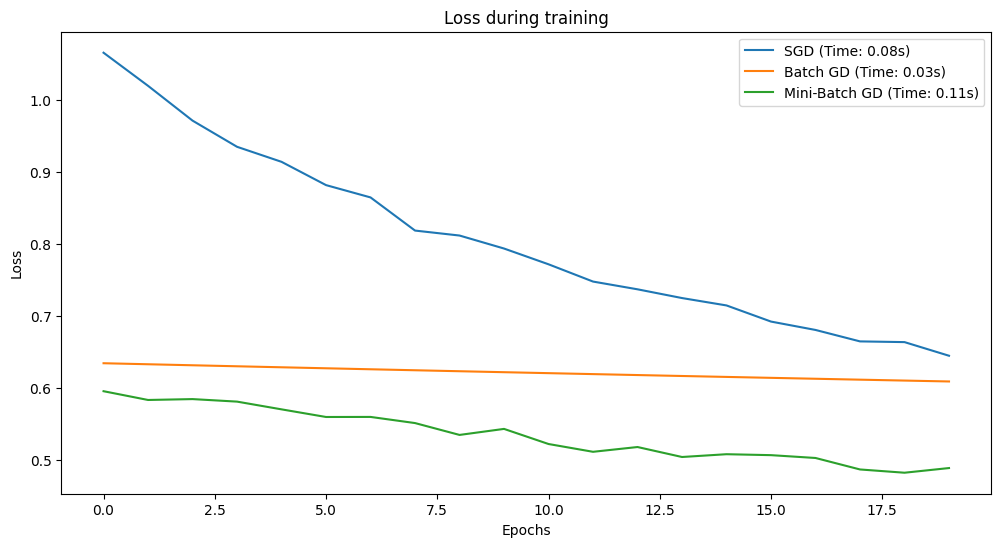

In [21]:
import matplotlib.pyplot as plt

# Graficar las pérdidas para cada método
plt.figure(figsize=(12, 6))

plt.plot(losses_sgd, label=f'SGD (Time: {time_sgd:.2f}s)')
plt.plot(losses_batch_gd, label=f'Batch GD (Time: {time_batch_gd:.2f}s)')
plt.plot(losses_mini_batch_gd, label=f'Mini-Batch GD (Time: {time_mini_batch_gd:.2f}s)')

plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Task 6 - Experimentación y análisis
Entrene los modelos con diferentes combinaciones de funciones de pérdida, técnicas de regularización y algoritmos de optimización. Para no complicar esta parte, puede dejar fijo dos de estos parámetros (función de pérdida, técnicas de regularización, algoritmo de optimización) y solamente cambiar uno de ellos. Deben verse al menos 9 combinaciones en total, donde es válido que en una de ellas no haya ninguna técnica de regularización. Si
quiere experimentar con más combinaciones se le dará hasta 10% de puntos extra. Para cada combinación registre métricas como precisión, pérdida y alguna otra métrica que considere pertinente (Recuerde lo visto en inteligencia artificial). Visualice las curvas (tanto en precisión, pérdida y la tercera métrica que decidió) de entrenamiento y validación utilizando bibliotecas como matplotlib y/o seaborn. Además, recuerde llevar tracking de los tiempos de ejecución de cada combinación. 

In [22]:
from sklearn.metrics import accuracy_score

# Función para evaluar precisión en el conjunto de validación
def evaluate_accuracy(model, val_loader):
    model.eval()  # Poner el modelo en modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():  # Desactivar cálculo de gradientes para la evaluación
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

# Modificar la función de entrenamiento para calcular la precisión
def train_model_with_accuracy(optimizer, train_loader, val_loader, model, criterion, num_epochs=20):
    train_losses = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()  # Modo de entrenamiento
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Limpiar gradientes

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Actualizar los parámetros

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluar precisión en el conjunto de validación
        accuracy = evaluate_accuracy(model, val_loader)
        val_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, val_accuracies, training_time


In [23]:
'''
Combinación 1

Fijo:
    LossFunc: CrossEntropyLoss
    OptAlg: SGD

Variable:
    RegTech: None

'''

# Definir el modelo y la función de pérdida
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()

# Algoritmo de optimización SGD sin regularización
optimizer_sgd_no_reg = optim.SGD(model.parameters(), lr=0.01)

# Entrenamiento
train_losses_no_reg, val_accuracies_no_reg, time_no_reg = train_model_with_accuracy(
    optimizer_sgd_no_reg, train_loader, val_loader, model, criterion)

Epoch [1/20], Loss: 1.1161, Accuracy: 0.3333
Epoch [2/20], Loss: 1.1098, Accuracy: 0.3667
Epoch [3/20], Loss: 1.0854, Accuracy: 0.4000
Epoch [4/20], Loss: 1.0864, Accuracy: 0.4333
Epoch [5/20], Loss: 1.0768, Accuracy: 0.4667
Epoch [6/20], Loss: 1.0690, Accuracy: 0.5000
Epoch [7/20], Loss: 1.0660, Accuracy: 0.5333
Epoch [8/20], Loss: 1.0511, Accuracy: 0.5667
Epoch [9/20], Loss: 1.0458, Accuracy: 0.5333
Epoch [10/20], Loss: 1.0414, Accuracy: 0.5667
Epoch [11/20], Loss: 1.0244, Accuracy: 0.6000
Epoch [12/20], Loss: 1.0187, Accuracy: 0.6000
Epoch [13/20], Loss: 1.0172, Accuracy: 0.6000
Epoch [14/20], Loss: 1.0012, Accuracy: 0.6000
Epoch [15/20], Loss: 0.9831, Accuracy: 0.6000
Epoch [16/20], Loss: 0.9816, Accuracy: 0.6000
Epoch [17/20], Loss: 0.9632, Accuracy: 0.6000
Epoch [18/20], Loss: 0.9637, Accuracy: 0.6000
Epoch [19/20], Loss: 0.9455, Accuracy: 0.6000
Epoch [20/20], Loss: 0.9358, Accuracy: 0.6000


In [24]:
'''
Combinación 2

Fijo:
    LossFunc: CrossEntropyLoss
    RegTech: Adam

Variable:
    RegTech: L2

'''

# Definir el modelo y la función de pérdida
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()

# Algoritmo de optimización Adam con regularización L2
optimizer_adam_l2 = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Entrenamiento
train_losses_adam_l2, val_accuracies_adam_l2, time_adam_l2 = train_model_with_accuracy(
    optimizer_adam_l2, train_loader, val_loader, model, criterion)

Epoch [1/20], Loss: 1.1217, Accuracy: 0.4000
Epoch [2/20], Loss: 1.1082, Accuracy: 0.4000
Epoch [3/20], Loss: 1.0917, Accuracy: 0.4000
Epoch [4/20], Loss: 1.0863, Accuracy: 0.4000
Epoch [5/20], Loss: 1.0697, Accuracy: 0.4000
Epoch [6/20], Loss: 1.0611, Accuracy: 0.4000
Epoch [7/20], Loss: 1.0515, Accuracy: 0.4000
Epoch [8/20], Loss: 1.0311, Accuracy: 0.4000
Epoch [9/20], Loss: 1.0125, Accuracy: 0.4333
Epoch [10/20], Loss: 0.9956, Accuracy: 0.4667
Epoch [11/20], Loss: 0.9763, Accuracy: 0.5667
Epoch [12/20], Loss: 0.9536, Accuracy: 0.7333
Epoch [13/20], Loss: 0.9264, Accuracy: 0.7667
Epoch [14/20], Loss: 0.9097, Accuracy: 0.7667
Epoch [15/20], Loss: 0.8701, Accuracy: 0.7667
Epoch [16/20], Loss: 0.8623, Accuracy: 0.7667
Epoch [17/20], Loss: 0.8201, Accuracy: 0.8000
Epoch [18/20], Loss: 0.7970, Accuracy: 0.8000
Epoch [19/20], Loss: 0.7655, Accuracy: 0.8000
Epoch [20/20], Loss: 0.7356, Accuracy: 0.8000


In [25]:
'''
Combinación 3

Fijo:
    RegTech: Dropout
    OptAlg: SDG

Variable:
    LossFunc: HingeLoss

'''

# Redefinir el modelo con Dropout
class SimpleFeedforwardNNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleFeedforwardNNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout = nn.Dropout(0.5)  # Añadir dropout
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Aplicar dropout
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

model = SimpleFeedforwardNNWithDropout(input_size, hidden_size1, hidden_size2, output_size)

# Hinge Loss
criterion = nn.MultiMarginLoss()

# Algoritmo de optimización SGD con Dropout
optimizer_sgd_dropout = optim.SGD(model.parameters(), lr=0.01)

# Entrenamiento
train_losses_sgd_dropout, val_accuracies_sgd_dropout, time_sgd_dropout = train_model_with_accuracy(
    optimizer_sgd_dropout, train_loader, val_loader, model, criterion)


Epoch [1/20], Loss: 0.6935, Accuracy: 0.2000
Epoch [2/20], Loss: 0.6751, Accuracy: 0.3000
Epoch [3/20], Loss: 0.6697, Accuracy: 0.3333
Epoch [4/20], Loss: 0.6682, Accuracy: 0.5000
Epoch [5/20], Loss: 0.6357, Accuracy: 0.4333
Epoch [6/20], Loss: 0.6249, Accuracy: 0.4667
Epoch [7/20], Loss: 0.6315, Accuracy: 0.4667
Epoch [8/20], Loss: 0.6176, Accuracy: 0.5000
Epoch [9/20], Loss: 0.5916, Accuracy: 0.5333
Epoch [10/20], Loss: 0.5773, Accuracy: 0.5333
Epoch [11/20], Loss: 0.5853, Accuracy: 0.5333
Epoch [12/20], Loss: 0.5749, Accuracy: 0.5667
Epoch [13/20], Loss: 0.5633, Accuracy: 0.5667
Epoch [14/20], Loss: 0.5618, Accuracy: 0.5667
Epoch [15/20], Loss: 0.5584, Accuracy: 0.5667
Epoch [16/20], Loss: 0.5331, Accuracy: 0.5667
Epoch [17/20], Loss: 0.5417, Accuracy: 0.5667
Epoch [18/20], Loss: 0.5314, Accuracy: 0.5667
Epoch [19/20], Loss: 0.5274, Accuracy: 0.5667
Epoch [20/20], Loss: 0.4989, Accuracy: 0.5667


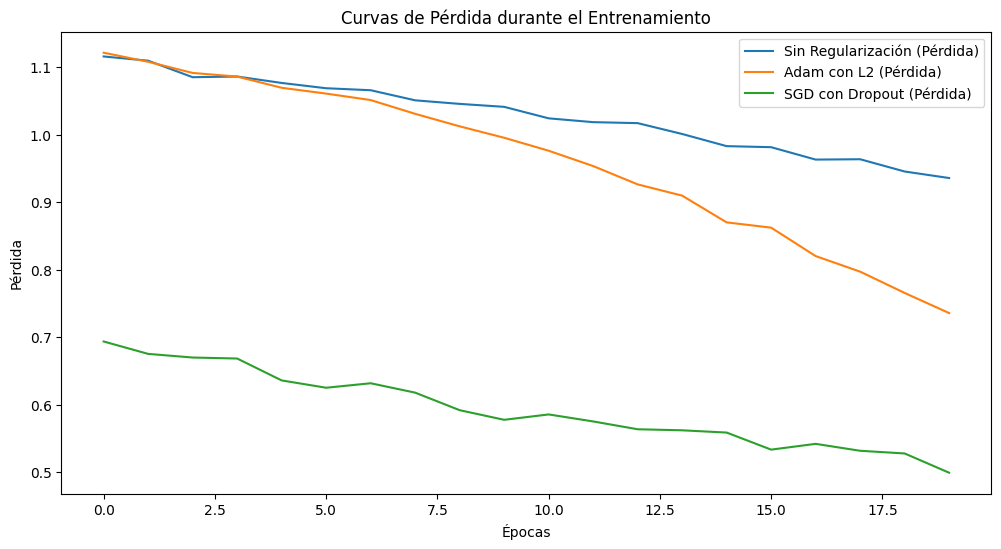

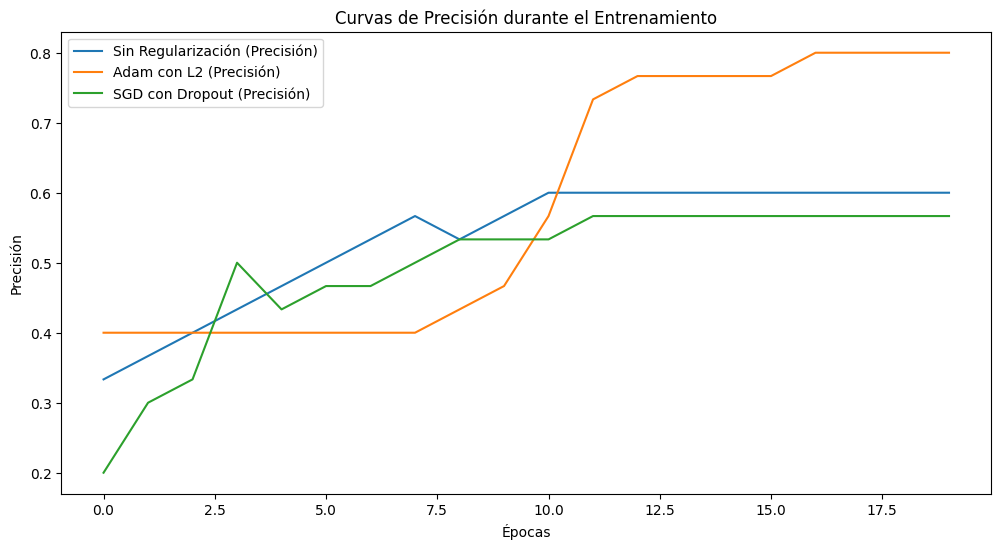

In [26]:
'''
Gráficas 1,2,3
'''

# Graficar curvas de pérdida
plt.figure(figsize=(12, 6))
plt.plot(train_losses_no_reg, label=f'Sin Regularización (Pérdida)')
plt.plot(train_losses_adam_l2, label=f'Adam con L2 (Pérdida)')
plt.plot(train_losses_sgd_dropout, label=f'SGD con Dropout (Pérdida)')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar curvas de precisión
plt.figure(figsize=(12, 6))
plt.plot(val_accuracies_no_reg, label=f'Sin Regularización (Precisión)')
plt.plot(val_accuracies_adam_l2, label=f'Adam con L2 (Precisión)')
plt.plot(val_accuracies_sgd_dropout, label=f'SGD con Dropout (Precisión)')
plt.title('Curvas de Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [27]:
'''
Combinación 4

Fijo:
    LossFunc: CrossEntropyLoss
    RegTech: L2
    
Variable:
    OptAlg: SDG

'''

# Definir el modelo y la función de pérdida
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()

# Algoritmo de optimización SGD con regularización L2
optimizer_sgd_l2 = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

# Entrenamiento
train_losses_sgd_l2, val_accuracies_sgd_l2, time_sgd_l2 = train_model_with_accuracy(
    optimizer_sgd_l2, train_loader, val_loader, model, criterion)


Epoch [1/20], Loss: 1.1735, Accuracy: 0.0000
Epoch [2/20], Loss: 1.1610, Accuracy: 0.0000
Epoch [3/20], Loss: 1.1502, Accuracy: 0.0000
Epoch [4/20], Loss: 1.1404, Accuracy: 0.0000
Epoch [5/20], Loss: 1.1306, Accuracy: 0.0000
Epoch [6/20], Loss: 1.1205, Accuracy: 0.0000
Epoch [7/20], Loss: 1.1119, Accuracy: 0.0333
Epoch [8/20], Loss: 1.1028, Accuracy: 0.2667
Epoch [9/20], Loss: 1.0944, Accuracy: 0.4000
Epoch [10/20], Loss: 1.0867, Accuracy: 0.4000
Epoch [11/20], Loss: 1.0784, Accuracy: 0.5667
Epoch [12/20], Loss: 1.0724, Accuracy: 0.6000
Epoch [13/20], Loss: 1.0645, Accuracy: 0.6667
Epoch [14/20], Loss: 1.0571, Accuracy: 0.6667
Epoch [15/20], Loss: 1.0478, Accuracy: 0.6667
Epoch [16/20], Loss: 1.0470, Accuracy: 0.7000
Epoch [17/20], Loss: 1.0382, Accuracy: 0.7000
Epoch [18/20], Loss: 1.0292, Accuracy: 0.7000
Epoch [19/20], Loss: 1.0226, Accuracy: 0.6667
Epoch [20/20], Loss: 1.0180, Accuracy: 0.6667


In [28]:
'''
Combinación 5

Fijo:
    LossFunc: CrossEntropyLoss
    OptAlg: Adam
    
Variable:
    RegTech: None

'''

# Definir el modelo y la función de pérdida
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()

# Algoritmo de optimización Adam sin regularización
optimizer_adam_no_reg = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
train_losses_adam_no_reg, val_accuracies_adam_no_reg, time_adam_no_reg = train_model_with_accuracy(
    optimizer_adam_no_reg, train_loader, val_loader, model, criterion)


Epoch [1/20], Loss: 1.1569, Accuracy: 0.3333
Epoch [2/20], Loss: 1.1418, Accuracy: 0.3667
Epoch [3/20], Loss: 1.1120, Accuracy: 0.4000
Epoch [4/20], Loss: 1.0901, Accuracy: 0.5000
Epoch [5/20], Loss: 1.0756, Accuracy: 0.6000
Epoch [6/20], Loss: 1.0641, Accuracy: 0.6667
Epoch [7/20], Loss: 1.0373, Accuracy: 0.6667
Epoch [8/20], Loss: 1.0200, Accuracy: 0.6667
Epoch [9/20], Loss: 1.0110, Accuracy: 0.6667
Epoch [10/20], Loss: 0.9911, Accuracy: 0.6667
Epoch [11/20], Loss: 0.9717, Accuracy: 0.6667
Epoch [12/20], Loss: 0.9459, Accuracy: 0.6667
Epoch [13/20], Loss: 0.9186, Accuracy: 0.6667
Epoch [14/20], Loss: 0.9104, Accuracy: 0.6667
Epoch [15/20], Loss: 0.8926, Accuracy: 0.6667
Epoch [16/20], Loss: 0.8525, Accuracy: 0.6667
Epoch [17/20], Loss: 0.8341, Accuracy: 0.6667
Epoch [18/20], Loss: 0.8050, Accuracy: 0.6667
Epoch [19/20], Loss: 0.7830, Accuracy: 0.6667
Epoch [20/20], Loss: 0.7679, Accuracy: 0.6667


In [29]:
'''
Combinación 6

Fijo:
    OptAlg: SGD
    RegTech: Droput
    
Variable:
    LossFunc: CrossEntropyLoss

'''

# Redefinir el modelo con Dropout
model = SimpleFeedforwardNNWithDropout(input_size, hidden_size1, hidden_size2, output_size)

# Función de pérdida CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Algoritmo de optimización SGD con Dropout
optimizer_sgd_dropout_ce = optim.SGD(model.parameters(), lr=0.01)

# Entrenamiento
train_losses_sgd_dropout_ce, val_accuracies_sgd_dropout_ce, time_sgd_dropout_ce = train_model_with_accuracy(
    optimizer_sgd_dropout_ce, train_loader, val_loader, model, criterion)


Epoch [1/20], Loss: 1.1358, Accuracy: 0.3333
Epoch [2/20], Loss: 1.1362, Accuracy: 0.3333
Epoch [3/20], Loss: 1.1152, Accuracy: 0.3333
Epoch [4/20], Loss: 1.1383, Accuracy: 0.3000
Epoch [5/20], Loss: 1.1201, Accuracy: 0.3000
Epoch [6/20], Loss: 1.1189, Accuracy: 0.3000
Epoch [7/20], Loss: 1.1282, Accuracy: 0.3000
Epoch [8/20], Loss: 1.1102, Accuracy: 0.3000
Epoch [9/20], Loss: 1.0957, Accuracy: 0.3000
Epoch [10/20], Loss: 1.1101, Accuracy: 0.3000
Epoch [11/20], Loss: 1.1019, Accuracy: 0.3333
Epoch [12/20], Loss: 1.0917, Accuracy: 0.4000
Epoch [13/20], Loss: 1.0903, Accuracy: 0.4000
Epoch [14/20], Loss: 1.1020, Accuracy: 0.4333
Epoch [15/20], Loss: 1.0881, Accuracy: 0.4667
Epoch [16/20], Loss: 1.0823, Accuracy: 0.4667
Epoch [17/20], Loss: 1.0737, Accuracy: 0.4667
Epoch [18/20], Loss: 1.0778, Accuracy: 0.4667
Epoch [19/20], Loss: 1.0670, Accuracy: 0.4667
Epoch [20/20], Loss: 1.0776, Accuracy: 0.4667


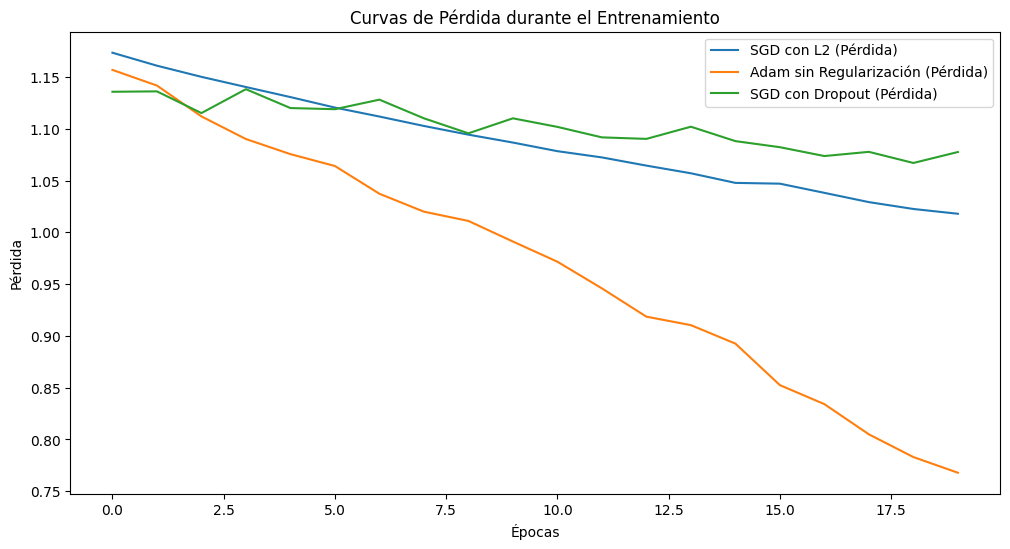

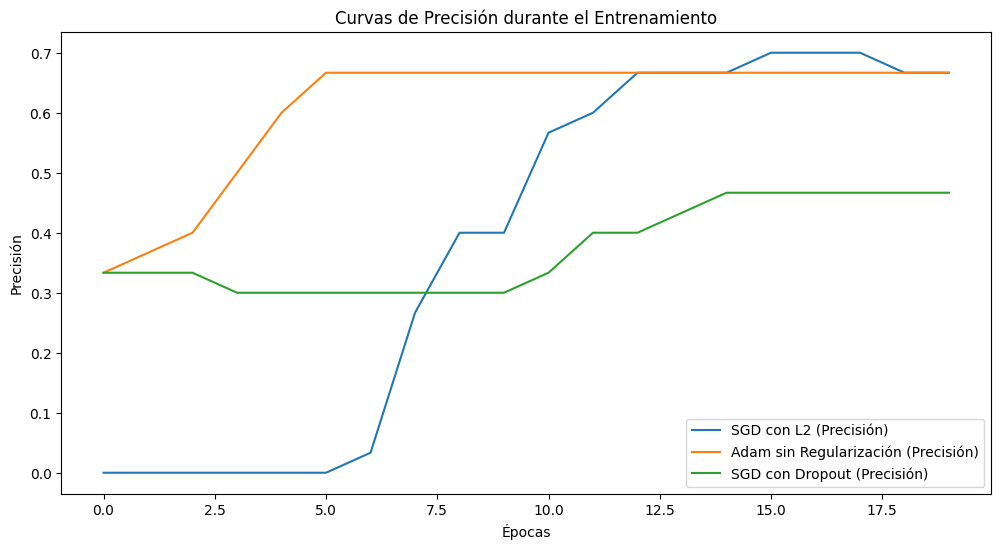

In [30]:
'''
Gráficas 4,5,6
'''

# Graficar curvas de pérdida
plt.figure(figsize=(12, 6))
plt.plot(train_losses_sgd_l2, label=f'SGD con L2 (Pérdida)')
plt.plot(train_losses_adam_no_reg, label=f'Adam sin Regularización (Pérdida)')
plt.plot(train_losses_sgd_dropout_ce, label=f'SGD con Dropout (Pérdida)')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar curvas de precisión
plt.figure(figsize=(12, 6))
plt.plot(val_accuracies_sgd_l2, label=f'SGD con L2 (Precisión)')
plt.plot(val_accuracies_adam_no_reg, label=f'Adam sin Regularización (Precisión)')
plt.plot(val_accuracies_sgd_dropout_ce, label=f'SGD con Dropout (Precisión)')
plt.title('Curvas de Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [31]:
'''
Combinación 7

Fijo:
    LossFunc: HingeLoss (MultiMarginLoss)
    RegTech: L2 (Weight Decay)
    
Variable:
    OptAlg: Adam

'''

# Definir el modelo y la función de pérdida
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.MultiMarginLoss()

# Algoritmo de optimización Adam con regularización L2
optimizer_adam_l2_hinge = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Entrenamiento
train_losses_adam_l2_hinge, val_accuracies_adam_l2_hinge, time_adam_l2_hinge = train_model_with_accuracy(
    optimizer_adam_l2_hinge, train_loader, val_loader, model, criterion)


Epoch [1/20], Loss: 0.6888, Accuracy: 0.3000
Epoch [2/20], Loss: 0.6714, Accuracy: 0.4000
Epoch [3/20], Loss: 0.6594, Accuracy: 0.4000
Epoch [4/20], Loss: 0.6551, Accuracy: 0.4000
Epoch [5/20], Loss: 0.6393, Accuracy: 0.4000
Epoch [6/20], Loss: 0.6244, Accuracy: 0.4000
Epoch [7/20], Loss: 0.6144, Accuracy: 0.4333
Epoch [8/20], Loss: 0.5940, Accuracy: 0.4333
Epoch [9/20], Loss: 0.5698, Accuracy: 0.4333
Epoch [10/20], Loss: 0.5533, Accuracy: 0.4333
Epoch [11/20], Loss: 0.5298, Accuracy: 0.4333
Epoch [12/20], Loss: 0.5018, Accuracy: 0.4333
Epoch [13/20], Loss: 0.4711, Accuracy: 0.4333
Epoch [14/20], Loss: 0.4516, Accuracy: 0.5000
Epoch [15/20], Loss: 0.4388, Accuracy: 0.7667
Epoch [16/20], Loss: 0.4208, Accuracy: 0.7667
Epoch [17/20], Loss: 0.4059, Accuracy: 0.7333
Epoch [18/20], Loss: 0.3784, Accuracy: 0.7000
Epoch [19/20], Loss: 0.3598, Accuracy: 0.7000
Epoch [20/20], Loss: 0.3511, Accuracy: 0.7000


In [32]:
'''
Combinación 8

Fijo:
    LossFunc: CrossEntropyLoss
    RegTech: L1 (Weight Decay)
    
Variable:
    OptAlg: SGD

'''
# Definir el modelo y la función de pérdida
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()

# Algoritmo de optimización SGD con regularización L1
optimizer_sgd_l1 = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

# Entrenamiento
train_losses_sgd_l1, val_accuracies_sgd_l1, time_sgd_l1 = train_model_with_accuracy(
    optimizer_sgd_l1, train_loader, val_loader, model, criterion)


Epoch [1/20], Loss: 1.1419, Accuracy: 0.3333
Epoch [2/20], Loss: 1.1296, Accuracy: 0.3333
Epoch [3/20], Loss: 1.1203, Accuracy: 0.3333
Epoch [4/20], Loss: 1.1147, Accuracy: 0.3333
Epoch [5/20], Loss: 1.0975, Accuracy: 0.3333
Epoch [6/20], Loss: 1.1036, Accuracy: 0.3333
Epoch [7/20], Loss: 1.0953, Accuracy: 0.3333
Epoch [8/20], Loss: 1.0848, Accuracy: 0.3333
Epoch [9/20], Loss: 1.0838, Accuracy: 0.3333
Epoch [10/20], Loss: 1.0775, Accuracy: 0.3333
Epoch [11/20], Loss: 1.0783, Accuracy: 0.3333
Epoch [12/20], Loss: 1.0745, Accuracy: 0.3333
Epoch [13/20], Loss: 1.0672, Accuracy: 0.3333
Epoch [14/20], Loss: 1.0651, Accuracy: 0.3333
Epoch [15/20], Loss: 1.0572, Accuracy: 0.3333
Epoch [16/20], Loss: 1.0572, Accuracy: 0.3333
Epoch [17/20], Loss: 1.0486, Accuracy: 0.3333
Epoch [18/20], Loss: 1.0467, Accuracy: 0.3333
Epoch [19/20], Loss: 1.0405, Accuracy: 0.3667
Epoch [20/20], Loss: 1.0362, Accuracy: 0.3667


In [33]:
'''
Combinación 9

Fijo:
    OptAlg: Adam
    RegTech: Dropout
    
Variable:
    LossFunc: CrossEntropyLoss

'''

# Redefinir el modelo con Dropout
model = SimpleFeedforwardNNWithDropout(input_size, hidden_size1, hidden_size2, output_size)

# Función de pérdida CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Algoritmo de optimización Adam con Dropout
optimizer_adam_dropout = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
train_losses_adam_dropout, val_accuracies_adam_dropout, time_adam_dropout = train_model_with_accuracy(
    optimizer_adam_dropout, train_loader, val_loader, model, criterion)


Epoch [1/20], Loss: 1.0886, Accuracy: 0.6667
Epoch [2/20], Loss: 1.0736, Accuracy: 0.6667
Epoch [3/20], Loss: 1.0734, Accuracy: 0.6667
Epoch [4/20], Loss: 1.0643, Accuracy: 0.6667
Epoch [5/20], Loss: 1.0408, Accuracy: 0.6667
Epoch [6/20], Loss: 1.0177, Accuracy: 0.6667
Epoch [7/20], Loss: 1.0208, Accuracy: 0.7000
Epoch [8/20], Loss: 1.0001, Accuracy: 0.7333
Epoch [9/20], Loss: 0.9994, Accuracy: 0.7667
Epoch [10/20], Loss: 0.9811, Accuracy: 0.8000
Epoch [11/20], Loss: 0.9629, Accuracy: 0.8667
Epoch [12/20], Loss: 0.9489, Accuracy: 0.8667
Epoch [13/20], Loss: 0.9294, Accuracy: 0.8667
Epoch [14/20], Loss: 0.9251, Accuracy: 0.8667
Epoch [15/20], Loss: 0.8855, Accuracy: 0.8667
Epoch [16/20], Loss: 0.8328, Accuracy: 0.9000
Epoch [17/20], Loss: 0.8415, Accuracy: 0.9000
Epoch [18/20], Loss: 0.8470, Accuracy: 0.8333
Epoch [19/20], Loss: 0.7558, Accuracy: 0.8333
Epoch [20/20], Loss: 0.7855, Accuracy: 0.8333


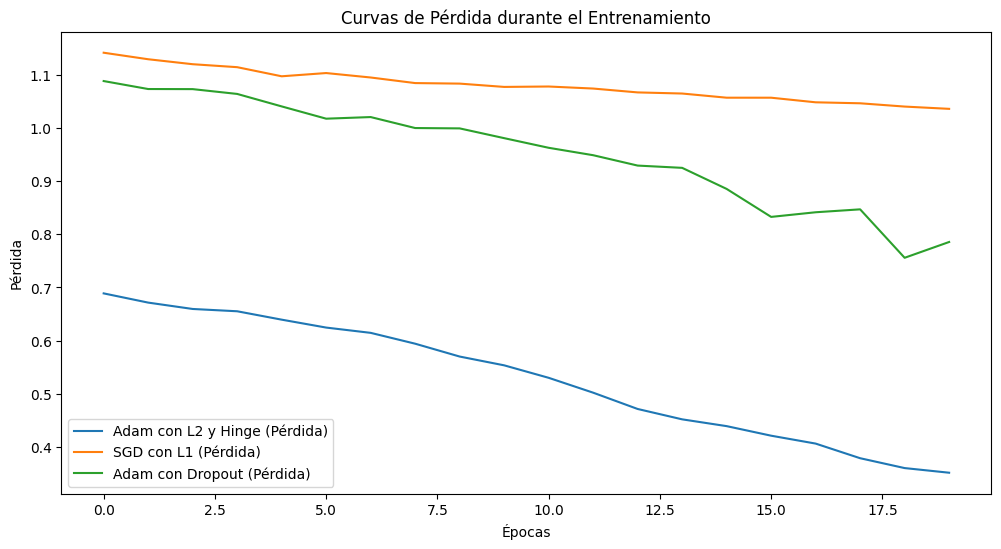

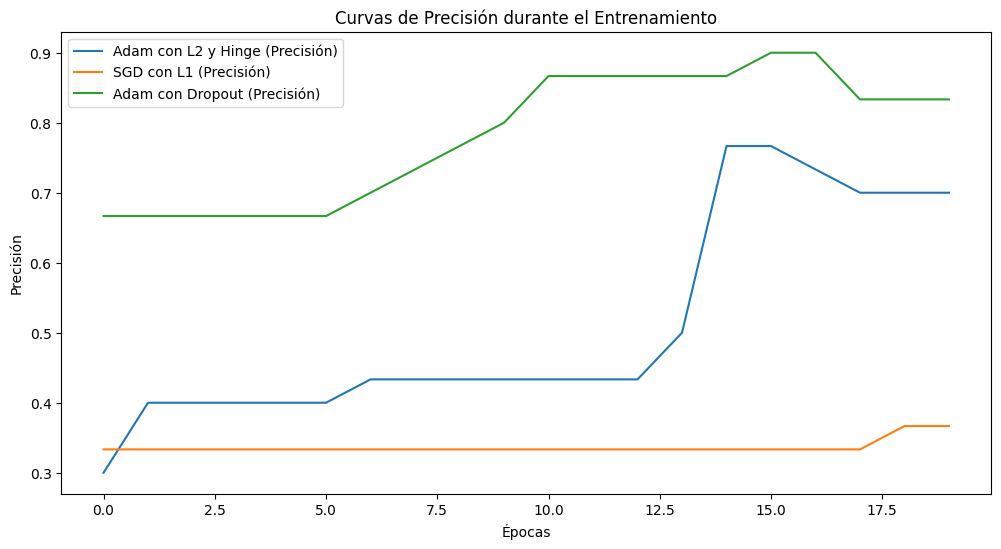

In [34]:
'''
Gráficas 7,8,9
'''
# Graficar curvas de pérdida
plt.figure(figsize=(12, 6))
plt.plot(train_losses_adam_l2_hinge, label=f'Adam con L2 y Hinge (Pérdida)')
plt.plot(train_losses_sgd_l1, label=f'SGD con L1 (Pérdida)')
plt.plot(train_losses_adam_dropout, label=f'Adam con Dropout (Pérdida)')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar curvas de precisión
plt.figure(figsize=(12, 6))
plt.plot(val_accuracies_adam_l2_hinge, label=f'Adam con L2 y Hinge (Precisión)')
plt.plot(val_accuracies_sgd_l1, label=f'SGD con L1 (Precisión)')
plt.plot(val_accuracies_adam_dropout, label=f'Adam con Dropout (Precisión)')
plt.title('Curvas de Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()



# Task 7 - Discusión

Discuta los resultados obtenidos de diferentes modelos. Compare la velocidad de convergencia y el rendimiento final de modelos utilizando diferentes funciones de pérdida, técnicas de regularización, y algoritmos de optimización. Explore y discuta por qué ciertas técnicas podrían conducir a un mejor rendimiento. tanto técnicas de regularización, funciones de pérdida como algoritmos de optimización. 

### Discusión:

Los resultados obtenidos muestran diferencias en rendimiento al hacer disntintas combinaciones. Algo que se puede destacar es que las combinaciones que empleaban Adam mostraban menor pérdida más rápido y similarmente mayor precisión. Mientras hubo otras que sí presentaron mal rendimiento como el SGD con L1. Esto puede ser debido a que Adam adapta la tasa de aprendizaje dinámicamente para cada parámetro, lo cual le da ventaja y rapidez de convergencia. Mientras que por ejemplo, el SGD, puede llegar a ser más lento y converger paulatinamente a comparación de Adam ya que la tasa de aprendizaje ahí es constante. Además que el SGD tiene el problema de que si los pasos son muy grandes o muy chicos, quede en mínimos locales y el modelo pierda desempeño. También tomando en cuenta los L1 y L2, tenemos que el L1 posee convergencia un poco más lenta y eso puede llevar a mayor pérdida. Mientras que el L2, al evitar que los pesos crezcan demasiado, se puede generalizar y ayuda a tener un proceso de optimización más suave. Por lo tanto, ciertas combinaciones como SGD y L1 podrían resultar en una convergencia lenta y mal desempeño, mientras otras como Adam con L2, pueden llevar a una convergencia rápida, buen desempeño y poca pérdida.